# Node representation learning with attri2vec

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/attri2vec-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/attri2vec-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This is the python implementation of the attri2vec algorithm outlined in paper [1]. The implementation uses the stellargraph components.

<a name="refs"></a>
**References:** 

[1] [Attributed Network Embedding via Subspace Discovery](https://link.springer.com/article/10.1007/s10618-019-00650-2). D. Zhang, Y. Jie, X. Zhu and C. Zhang, Data Mining and Knowledge Discovery, 2019. 

## attri2vec

attri2vec learns node representations by performing a linear/non-linear mapping on node content attributes. To make the learned node representations respect structural similarity, [DeepWalk](https://dl.acm.org/citation.cfm?id=2623732)/[Node2Vec](https://snap.stanford.edu/node2vec) learning mechanism is used to make nodes sharing similar random walk context nodes represented closely in the subspace. 

For each (``target``,``context``) node pair $(v_i,v_j)$ collected from random walks,  attri2vec learns the representation for the target node $v_i$ by using it to predict the existence of context node $v_j$, with the following three-layer neural network.

![](attri2vec-illustration.png)

Node $v_i$'s representation in the hidden layer is obtained by multiplying $v_i$'s raw content feature vector in the input layer with the input-to-hidden weight matrix $W_{in}$ followed by an activation function. To obtain the hidden-layer representation, the one-layer mapping can be replaced by multi-layer mappings. The existence probability of each node conditioned on node $v_i$ is outputted in the output layer, which is obtained by multiplying $v_i$'s hidden-layer representation with the hidden-to-out weight matrix $W_{out}$ followed by a softmax activation. To capture the ``target-context`` relation between $v_i$ and $v_j$, we need to maximize the probability $\mathrm{P}(v_j|v_i)$. However, computing $\mathrm{P}(v_j|v_i)$ is time consuming, which involves the matrix multiplication between $v_i$'s hidden-layer representation and the hidden-to-out weight matrix $W_{out}$.

To speed up the computing, we adopt the negative sampling strategy [1]. For each (``target``, ``context``) node pair, we sample a negative node $v_k$, which is not $v_i$'s context. To obtain the output, instead of multiplying $v_i$'s hidden-layer representation with the hidden-to-out weight matrix $W_{out}$ followed by a softmax activation, we only calculate the dot product between $v_i$'s hidden-layer representation and the $j$th column as well as the $k$th column of the hidden-to-output weight matrix $W_{out}$ followed by a sigmoid activation respectively. According to [1], the original objective to maximize $\mathrm{P}(v_j|v_i)$ can be approximated by minimizing the cross entropy between $v_j$ and $v_k$'s outputs and their ground-truth labels (1 for $v_j$ and 0 for $v_k$).

The entire model is trained end-to-end by minimizing the binary cross-entropy loss function with regards to predicted node pair labels and true node pair labels, using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' node pairs generated on demand and fed into the model.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from pandas.core.indexes.base import Index

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from stellargraph import datasets
from IPython.display import display, HTML

## Dataset

For clarity we ignore isolated nodes and subgraphs and use only the largest connected component.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, subjects = dataset.load(largest_connected_component_only=True)

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2110, Edges: 3757

 Node types:
  paper: [2110]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [3757]


## Train attri2vec on Citeseer

Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk.

In [6]:
nodes = list(G.nodes())
number_of_walks = 4
length = 5

Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [7]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

Set the batch size and the number of epochs. 

In [8]:
batch_size = 50
epochs = 4

Define an attri2vec training generator, which generates a batch of (feature of target node, index of context node, label of node pair) pairs per iteration.

In [9]:
generator = Attri2VecLinkGenerator(G, batch_size)
train_gen = generator.flow(unsupervised_samples)

Building the model: a 1-hidden-layer node representation ('input embedding') of the `target` node and the parameter vector ('output embedding') for predicting the existence of `context node` for each `(target context)` pair, with a link classification layer performed on the dot product of the 'input embedding' of the `target` node and the 'output embedding' of the `context` node.

Attri2Vec part of the model, with a 128-dimension hidden layer, no bias term and no normalization. (Normalization can be set to 'l2'). 

In [10]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [11]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.in_out_tensors()

Use the link_classification function to generate the prediction, with the `ip` edge embedding generation method and the `sigmoid` activation, which actually performs the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node followed by a sigmoid activation. 

In [12]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the Attri2Vec encoder and prediction layer into a Keras model, and specify the loss.

In [13]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Train the model.

In [14]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/4
1351/1351 - 25s - loss: 0.6847 - binary_accuracy: 0.5540
Epoch 2/4
1351/1351 - 27s - loss: 0.5482 - binary_accuracy: 0.7233
Epoch 3/4
1351/1351 - 31s - loss: 0.3638 - binary_accuracy: 0.8644
Epoch 4/4
1351/1351 - 31s - loss: 0.2639 - binary_accuracy: 0.9109


##  Visualise Node Embeddings

Build the node based model for predicting node representations from node content attributes with the learned parameters. Below a Keras model is constructed, with `x_inp[0]` as input and `x_out[0]` as output. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [15]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Get the node embeddings by applying the learned mapping function to node content features.

In [16]:
node_gen = Attri2VecNodeGenerator(G, batch_size).flow(subjects.index)
node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=1)

43/43 [==============================] - 0s 3ms/step


Transform the embeddings to 2d space for visualisation.

In [17]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

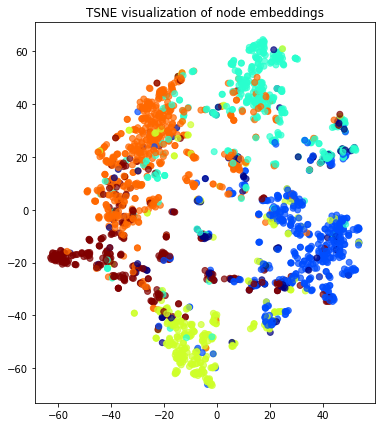

In [18]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

## Downstream Task

The node representations learned by attri2vec can be used as features for downstream tasks, such as node classification, community detection, and link prediction. As attri2vec inductively learns a mapping function from node content features to the target embeddings, it has the ability to infer the representations for out-of-sample nodes, which can be used to predict the labels or links of out-of-sample nodes.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/attri2vec-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/attri2vec-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>